Kernel size: 8. 
1D Convolutional layer


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import matplotlib as mpl
import sklearn

In [3]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('./drive/MyDrive/GNRA_pred/T_frames_train.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('./drive/MyDrive/GNRA_pred/labels_train.npy')
y_train = y_flt_train.astype(int)

dict_test = np.load('./drive/MyDrive/GNRA_pred/T_frames_test.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('./drive/MyDrive/GNRA_pred/labels_test.npy')
y_test = y_flt_test.astype(int)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)


Training features shape: (10749, 8, 4)
Test features shape: (5398, 8, 4)
Training labels shape: (10749,)
Test labels shape: (5398,)


In [4]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [5]:
neg, pos = np.bincount(y_train)+np.bincount(y_test)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)


Examples:
    Total: 16147
    Positive: 9931 (61.50% of total)

Training labels shape: (10749,)
Test labels shape: (5398,)
Training features shape: (10749, 8, 4)
Test features shape: (5398, 8, 4)


In [6]:
def make_model1(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(16, 3, strides=1, activation='relu',padding='same', 
                 input_shape=(8, 4),
                 kernel_initializer='he_normal', 
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(1, activation='sigmoid')  #Sigmoid for binary question.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
  
  return model


In [7]:
def make_model2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', 
                 input_shape=(8, 4),
                 kernel_initializer='he_normal', 
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(1, activation='sigmoid')  #Sigmoid for binary question.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
  
  return model

In [8]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  # plt.semilogy(history.epoch, history.history['val_loss'],
  #              color=colors[n], label='Val ' + label,
  #              linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [9]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [20]:
def plot_metrics(history1, history2):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [32]:
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.rcParams['font.size'] = '16'
  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [52]:
def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [13]:
# retrain with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.30
Weight for class 1: 0.81


In [17]:
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

weighted_history1 = weighted_model1.fit(
    x_train,
    y_train, 
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 1.30, 1: 0.81})

Epoch 1/20
672/672 [==============================] - 8s 6ms/step - loss: 0.3824 - tp: 8743.0000 - fp: 836.0000 - tn: 5380.0000 - fn: 1188.0000 - accuracy: 0.8747 - precision: 0.9127 - recall: 0.8804 - auc: 0.9532 - prc: 0.9691 - val_loss: 0.1457 - val_tp: 3143.0000 - val_fp: 91.0000 - val_tn: 1996.0000 - val_fn: 168.0000 - val_accuracy: 0.9520 - val_precision: 0.9719 - val_recall: 0.9493 - val_auc: 0.9860 - val_prc: 0.9873
Epoch 2/20
672/672 [==============================] - 3s 4ms/step - loss: 0.2116 - tp: 6126.0000 - fp: 383.0000 - tn: 3746.0000 - fn: 494.0000 - accuracy: 0.9184 - precision: 0.9412 - recall: 0.9254 - auc: 0.9726 - prc: 0.9796 - val_loss: 0.1082 - val_tp: 3225.0000 - val_fp: 70.0000 - val_tn: 2017.0000 - val_fn: 86.0000 - val_accuracy: 0.9711 - val_precision: 0.9788 - val_recall: 0.9740 - val_auc: 0.9900 - val_prc: 0.9926
Epoch 3/20
672/672 [==============================] - 3s 4ms/step - loss: 0.1714 - tp: 6239.0000 - fp: 272.0000 - tn: 3857.0000 - fn: 381.0000 - a

In [18]:
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

weighted_history2 = weighted_model2.fit(
    x_train,
    y_train, 
    validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 1.30, 1: 0.81})

Epoch 1/20
672/672 [==============================] - 6s 6ms/step - loss: 0.2853 - tp: 9098.0000 - fp: 611.0000 - tn: 5605.0000 - fn: 833.0000 - accuracy: 0.9106 - precision: 0.9371 - recall: 0.9161 - auc: 0.9727 - prc: 0.9811 - val_loss: 0.0973 - val_tp: 3207.0000 - val_fp: 59.0000 - val_tn: 2028.0000 - val_fn: 104.0000 - val_accuracy: 0.9698 - val_precision: 0.9819 - val_recall: 0.9686 - val_auc: 0.9931 - val_prc: 0.9956
Epoch 2/20
672/672 [==============================] - 3s 4ms/step - loss: 0.1275 - tp: 6344.0000 - fp: 177.0000 - tn: 3952.0000 - fn: 276.0000 - accuracy: 0.9579 - precision: 0.9729 - recall: 0.9583 - auc: 0.9886 - prc: 0.9913 - val_loss: 0.0766 - val_tp: 3248.0000 - val_fp: 60.0000 - val_tn: 2027.0000 - val_fn: 63.0000 - val_accuracy: 0.9772 - val_precision: 0.9819 - val_recall: 0.9810 - val_auc: 0.9960 - val_prc: 0.9976
Epoch 3/20
672/672 [==============================] - 3s 4ms/step - loss: 0.1082 - tp: 6401.0000 - fp: 151.0000 - tn: 3978.0000 - fn: 219.0000 - ac

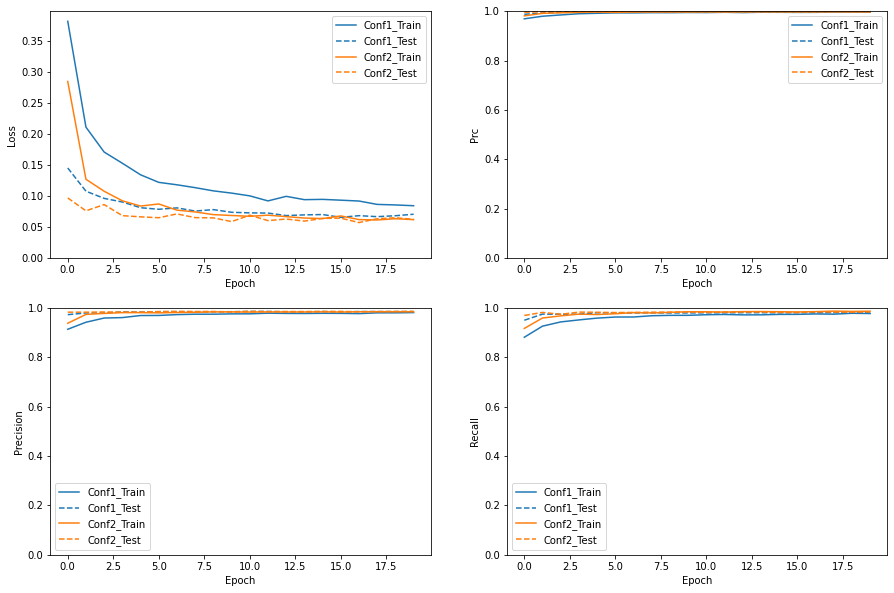

In [21]:
plot_metrics(weighted_history1, weighted_history2)

In [23]:
train_predictions_weighted1 = weighted_model1.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted1 = weighted_model1.predict(x_test, batch_size=BATCH_SIZE)

In [24]:
train_predictions_weighted2 = weighted_model2.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted2 = weighted_model2.predict(x_test, batch_size=BATCH_SIZE)

loss :  0.07105746120214462
tp :  3242.0
fp :  52.0
tn :  2035.0
fn :  69.0
accuracy :  0.9775843024253845
precision :  0.9842137098312378
recall :  0.9791603684425354
auc :  0.9958873987197876
prc :  0.9968579411506653

Non-GNRA Detected (True Negatives):  2035
Non-GNRA Incorrectly Detected (False Positives):  52
GNRA Missed (False Negatives):  69
GNRA Detected (True Positives):  3242
Total GNRA:  3311


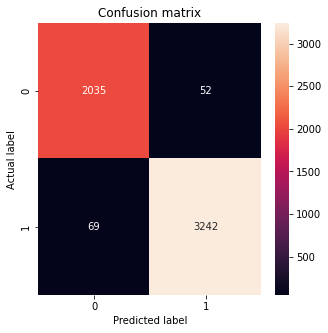

In [25]:
# Results of test data set. 
weighted_results1 = weighted_model1.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model1.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted1)

loss :  0.07105746120214462
tp :  3242.0
fp :  52.0
tn :  2035.0
fn :  69.0
accuracy :  0.9775843024253845
precision :  0.9842137098312378
recall :  0.9791603684425354
auc :  0.9958873987197876
prc :  0.9968579411506653

Non-GNRA Detected (True Negatives):  2038
Non-GNRA Incorrectly Detected (False Positives):  49
GNRA Missed (False Negatives):  56
GNRA Detected (True Positives):  3255
Total GNRA:  3311


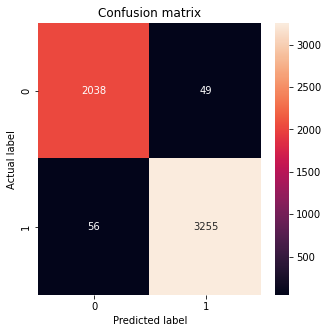

In [26]:
# Results of test data set. 
weighted_results2 = weighted_model2.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model2.metrics_names, weighted_results1):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted2)

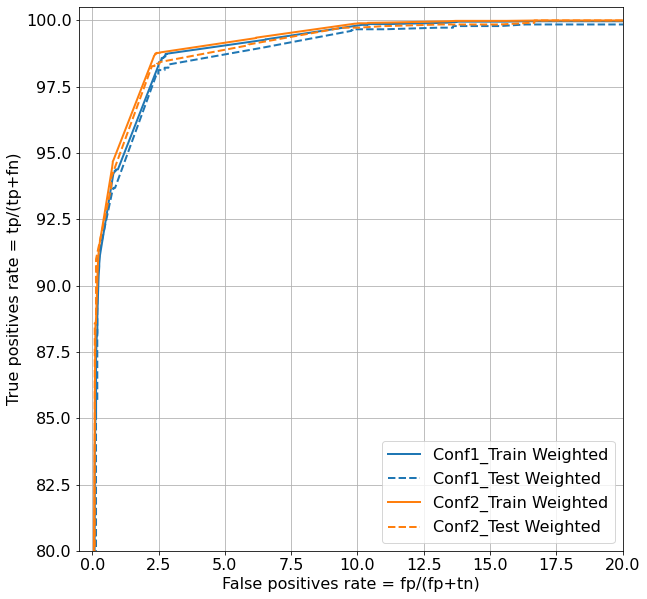

In [33]:
plot_roc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_roc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_roc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_roc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

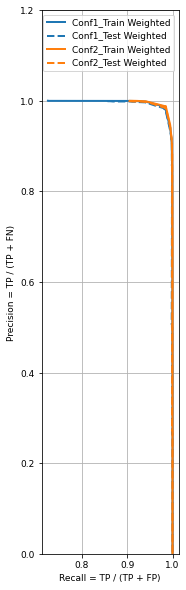

In [53]:
plot_prc("Conf1_Train Weighted", y_train, train_predictions_weighted1, color=colors[0])
plot_prc("Conf1_Test Weighted", y_test, test_predictions_weighted1, color=colors[0], linestyle='--')
plot_prc("Conf2_Train Weighted", y_train, train_predictions_weighted2, color=colors[1])
plot_prc("Conf2_Test Weighted", y_test, test_predictions_weighted2, color=colors[1], linestyle='--')
# plt.xlim([0, 1.2])
plt.ylim([0, 1.2])

plt.legend(loc='upper right');